In [2]:
from fastai.vision.all import *
from fastai.vision.widgets import *

In [3]:
catPath = Path('catPics')
catFiles = get_image_files(catPath)
catFiles

(#622) [Path('catPics/belly up/00000002.jpg'),Path('catPics/belly up/00000028.jpg'),Path('catPics/belly up/00000117.jpg'),Path('catPics/belly up/00000108.jpg'),Path('catPics/belly up/00000057.jpg'),Path('catPics/belly up/00000053.jpg'),Path('catPics/belly up/00000130.jpg'),Path('catPics/belly up/00000030.jpg'),Path('catPics/belly up/00000094.jpg'),Path('catPics/belly up/00000091.JPG')...]

In [4]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #TODO: make a splitter that splits it 3 ways, valid, test, and train without using GrandParent
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.3),
    batch_tfms=aug_transforms())

In [5]:
catDls = cats.dataloaders(catPath)

/home/itprentice/miniconda3/envs/fastbook_learning/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


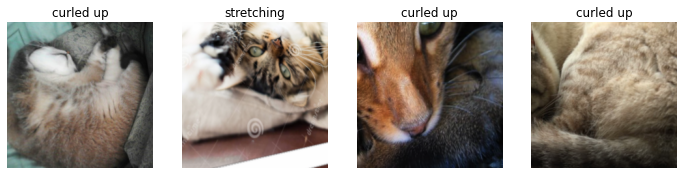

In [6]:
catDls.train.show_batch(max_n=4, nrows=1, unique=False)

In [13]:
#loads the exported inferer and saves it
catInf = load_learner('catexport.pkl')
save = catInf.save('catsave.pkl')
#loads the weights from the exported inferer into an identical cnn_learner as the one catInf was trained on
catLearn = cnn_learner(catDls, resnet34, metrics=error_rate)
catLearn.load('catsave.pkl') #loads the save file
os.remove(save) #removes the save file once it is loaded because it is large
os.rmdir(str(save).split('/')[0]) #removes the models folders

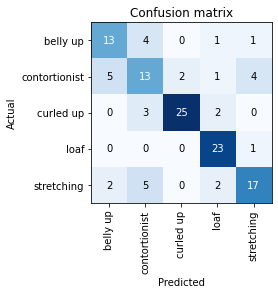

In [14]:
interp = ClassificationInterpretation.from_learner(catLearn)
interp.plot_confusion_matrix()

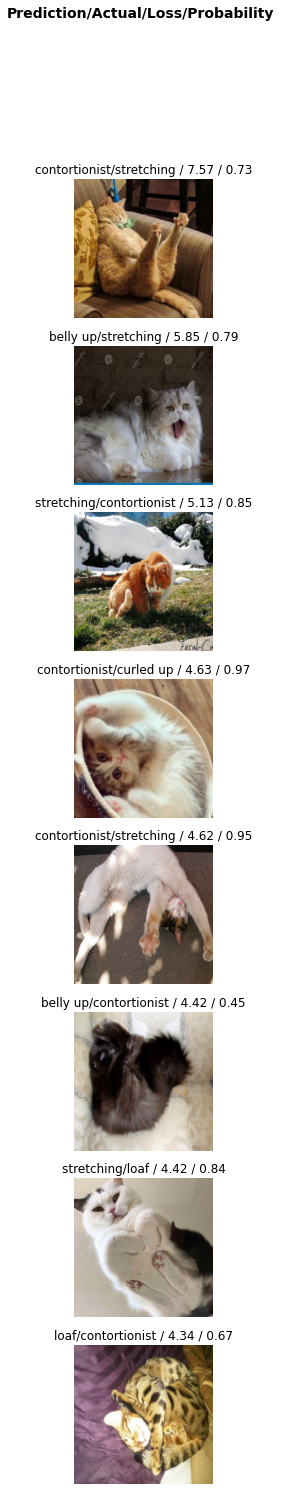

In [15]:
interp.plot_top_losses(8, nrows=8)

In [14]:
cleaner = ImageClassifierCleaner(catLearn)
cleaner

FileNotFoundError: [Errno 2] No such file or directory: '/home/itprentice/Documents/projects/cat-pos-engine/catPics/stretching/00000107.jpg'

In [43]:
#use this to check if your selection has been properly set
print(cleaner.delete())
cleaner.change()

[13]


(#1) [(8, 'belly up')]

In [44]:
#run this once you have cleaned the data for the selected categories
#this will actually do the file changes

#loops through the files marked for deletion and uses unlink() to delete them
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

#loops through the images marked to be moved and moves them to the appropriate folder, according to the structure:
# catPath/label/imagefile
for idx, catg in cleaner.change():
    #first attempts to use the same filename
    temp = str(catPath/catg)+"/"+str(cleaner.fns[idx]).split('/')[2]

    #changes the name of the destination file if it already exists
    while (os.path.exists(temp)):
        temp = str(catPath/catg)+"/1"+temp.split('/')[2] #adds a 1 to the front of the filename
        
    #once a filename that is not taken is made, moves the marked file with the new name 
    shutil.move(str(cleaner.fns[idx]), Path(temp))